In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/commandes-robot/sensor_readings_4.csv
/kaggle/input/commandes-robot/sensor_readings_24.csv


In [2]:
# 1) Importation des données 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2026-01-16 13:09:31.828199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768568972.065950      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768568972.131541      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768568972.684825      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768568972.684873      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768568972.684875      55 computation_placer.cc:177] computation placer alr

In [3]:
# 2) Chargement des données

PATH_24 = "/kaggle/input/commandes-robot/sensor_readings_24.csv"
PATH_4  = "/kaggle/input/commandes-robot/sensor_readings_4.csv"

df24 = pd.read_csv(PATH_24, header=None)
df4  = pd.read_csv(PATH_4,  header=None)

print("Dimensions du tableau sensor 24 : " ,df24.shape)

# X: 24 capteurs, y: 4 capteurs (on enlève la dernière colonne)
X_df = df24.iloc[:, :-1].copy()
y_df = df4.iloc[:, :-1].copy()

assert X_df.shape[0] == y_df.shape[0]
print("X:", X_df.shape, "y:", y_df.shape)

Dimensions du tableau sensor 24 :  (5456, 25)
X: (5456, 24) y: (5456, 4)


In [4]:
# 3) Split des données suivant (70% TRAIN - 15% VAL - 15% TEST)

idx = X_df.index
idx_train, idx_temp = train_test_split(idx, test_size=0.30, random_state=42, shuffle=True)
idx_val, idx_test   = train_test_split(idx_temp, test_size=0.50, random_state=42, shuffle=True)

X_train, y_train = X_df.loc[idx_train], y_df.loc[idx_train]
X_val,   y_val   = X_df.loc[idx_val],   y_df.loc[idx_val]

# à utiliser aussi pour tester le système globale
X_test,  y_test  = X_df.loc[idx_test],  y_df.loc[idx_test]

# En numpy 
y_train = y_train.to_numpy()
y_val   = y_val.to_numpy()
y_test  = y_test.to_numpy()

In [5]:
# 4) Mise à l'échelle
scalerX = StandardScaler().fit(X_train)

X_train_s = scalerX.transform(X_train)
X_val_s   = scalerX.transform(X_val)
X_test_s  = scalerX.transform(X_test)

In [6]:

# 5) Build / Train (3 seeds) — affichage console par config

def build_model(layers_list, input_dim=24, output_dim=4, lr=1e-3):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for n in layers_list:
        model.add(layers.Dense(n, activation="relu"))
    model.add(layers.Dense(output_dim, activation="linear"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model


SEEDS = [0, 1, 2]
EPOCHS = 200
BATCH_SIZE = 128


def run_config(cfg, seeds=SEEDS, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """
    Pour une config donnée :
    - lance 3 seeds
    - affiche les métriques
    - retourne les résultats
    """
    print("\n" + "="*70)
    print(f"▶ Lancement config layers = {cfg['Couches']}")
    print("="*70)

    rows = []
    val_maes = []

    for i, seed in enumerate(seeds, start=1):
        print(f"\n  Seed {i}/{len(seeds)} (seed={seed})")

        tf.keras.utils.set_random_seed(seed)

        model = build_model(cfg["Couches"])
        params = model.count_params()

        hist = model.fit(
            X_train_s, y_train,
            validation_data=(X_val_s, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[es]
        )

        val_mae_best = float(np.min(hist.history["val_mae"]))
        test_loss, test_mae = model.evaluate(X_test_s, y_test, verbose=0)

        val_maes.append(val_mae_best)

        print(f"    → val_mae_best = {val_mae_best:.5f} | test_mae = {test_mae:.5f} | epochs = {len(hist.history['loss'])}")

        rows.append({
            "layers": tuple(cfg["Couches"]),
            "params": int(params),
            "seed": int(seed),
            "val_mae_best": val_mae_best,
            "test_mae": float(test_mae),
            "epochs_trained": int(len(hist.history["loss"]))
        })

        keras.backend.clear_session()

    # résumé config
    print("\n  Résumé config", cfg["Couches"])
    print(f"    → val_mae_mean = {np.mean(val_maes):.5f} | val_mae_std = {np.std(val_maes):.5f}")

    return rows


I0000 00:00:1768568985.864843      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768568985.868857      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/300


I0000 00:00:1768568988.013794     125 service.cc:152] XLA service 0x78f4dc005130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768568988.013830     125 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768568988.013834     125 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768568988.228053     125 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768568988.928081     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 - 3s - 87ms/step - loss: 3.3597 - mae: 1.5659 - val_loss: 2.6117 - val_mae: 1.3683
Epoch 2/300
30/30 - 0s - 5ms/step - loss: 2.1085 - mae: 1.2192 - val_loss: 1.6769 - val_mae: 1.0699
Epoch 3/300
30/30 - 0s - 4ms/step - loss: 1.3449 - mae: 0.9520 - val_loss: 1.0825 - val_mae: 0.8404
Epoch 4/300
30/30 - 0s - 4ms/step - loss: 0.8610 - mae: 0.7439 - val_loss: 0.7127 - val_mae: 0.6683
Epoch 5/300
30/30 - 0s - 4ms/step - loss: 0.5767 - mae: 0.5971 - val_loss: 0.5041 - val_mae: 0.5572
Epoch 6/300
30/30 - 0s - 4ms/step - loss: 0.4258 - mae: 0.5078 - val_loss: 0.3917 - val_mae: 0.4899
Epoch 7/300
30/30 - 0s - 4ms/step - loss: 0.3464 - mae: 0.4561 - val_loss: 0.3277 - val_mae: 0.4469
Epoch 8/300
30/30 - 0s - 4ms/step - loss: 0.2985 - mae: 0.4218 - val_loss: 0.2857 - val_mae: 0.4154
Epoch 9/300
30/30 - 0s - 4ms/step - loss: 0.2648 - mae: 0.3956 - val_loss: 0.2554 - val_mae: 0.3907
Epoch 10/300
30/30 - 0s - 4ms/step - loss: 0.2397 - mae: 0.3748 - val_loss: 0.2327 - val_mae: 0.3709
Epoch 11/3

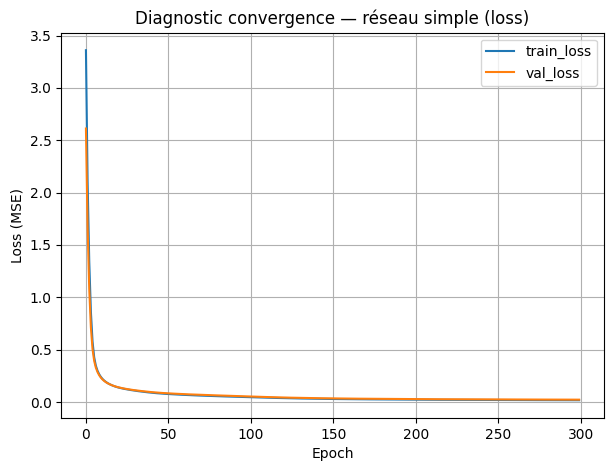

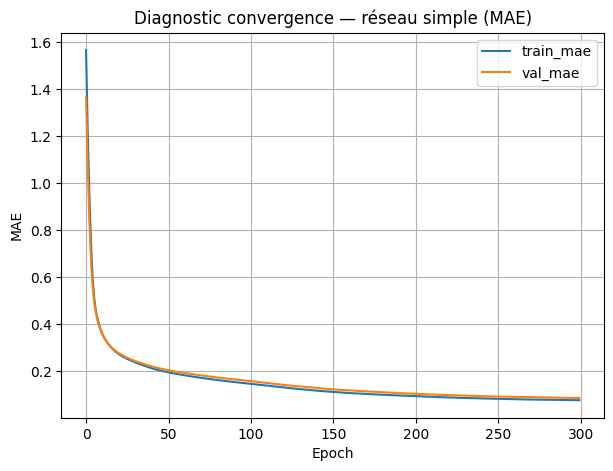

⏱️ Convergence atteinte en 300 epochs


In [7]:
# ============================================================
# Diagnostic de convergence — choix du nombre maximal d'epochs
# (réseau simple de référence)
# ============================================================

# Réseau simple de référence (1 couche, complexité faible)
reference_layers = [30]

tf.keras.utils.set_random_seed(0)

ref_model = build_model(reference_layers)

early_stop_ref = keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=10,
    restore_best_weights=True,
    mode="min"
)

history_ref = ref_model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=300,              # volontairement large pour observer la convergence
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=[early_stop_ref]
)

# --------------------------
# Visualisation convergence
# --------------------------

plt.figure(figsize=(7,5))
plt.plot(history_ref.history["loss"], label="train_loss")
plt.plot(history_ref.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Diagnostic convergence — réseau simple (loss)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.plot(history_ref.history["mae"], label="train_mae")
plt.plot(history_ref.history["val_mae"], label="val_mae")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Diagnostic convergence — réseau simple (MAE)")
plt.grid(True)
plt.legend()
plt.show()

print(" Convergence atteinte en", len(history_ref.history["loss"]), "epochs")

# Nettoyage
keras.backend.clear_session()

In [8]:
# CONCEPTION du plan d'expériences

neurons = [10, 15, 20, 25, 30, 40]
configs = []

# 1 couche
for n1 in neurons:
    configs.append({"Couches": [n1]})

# 2 couches (triangulaire décroissant)
for n1 in neurons:
    for n2 in neurons:
        if n2 < n1:
            configs.append({"Couches": [n1, n2]})

print("Nb configs:", len(configs))

Nb configs: 21


In [9]:
# 6) Lancer toutes les configs (chaque config -> 3 seeds) + DataFrame results
all_rows = []

for k, cfg in enumerate(configs, start=1):
    print(f"\n\n ---CONFIG {k}/{len(configs)}---")
    all_rows.extend(run_config(cfg))   # run_config affiche déjà les métriques



########## CONFIG 1/21 ##########

▶ Lancement config layers = [10]

  Seed 1/3 (seed=0)
    → val_mae_best = 0.17590 | test_mae = 0.17809 | epochs = 200

  Seed 2/3 (seed=1)
    → val_mae_best = 0.13602 | test_mae = 0.13695 | epochs = 200

  Seed 3/3 (seed=2)
    → val_mae_best = 0.16810 | test_mae = 0.16850 | epochs = 200

  Résumé config [10]
    → val_mae_mean = 0.16001 | val_mae_std = 0.01726


########## CONFIG 2/21 ##########

▶ Lancement config layers = [15]

  Seed 1/3 (seed=0)
    → val_mae_best = 0.12490 | test_mae = 0.12695 | epochs = 200

  Seed 2/3 (seed=1)
    → val_mae_best = 0.11173 | test_mae = 0.11067 | epochs = 200

  Seed 3/3 (seed=2)
    → val_mae_best = 0.13999 | test_mae = 0.14091 | epochs = 200

  Résumé config [15]
    → val_mae_mean = 0.12554 | val_mae_std = 0.01155


########## CONFIG 3/21 ##########

▶ Lancement config layers = [20]

  Seed 1/3 (seed=0)
    → val_mae_best = 0.11014 | test_mae = 0.10801 | epochs = 200

  Seed 2/3 (seed=1)
    → val_mae_bes

In [10]:
results = pd.DataFrame(all_rows)

print("\n Terminé.")
print("Nb runs (configs * seeds):", len(results))
display(results)


✅ Terminé.
Nb runs (configs * seeds): 63


,layers,params,seed,val_mae_best,test_mae,epochs_trained
0,"(10,)",294,0,0.175903,0.178090,200
1,"(10,)",294,1,0.136017,0.136945,200
2,"(10,)",294,2,0.168103,0.168501,200
3,"(15,)",439,0,0.124900,0.126946,200
4,"(15,)",439,1,0.111727,0.110670,200
...,...,...,...,...,...,...
58,"(40, 25)",2129,1,0.075279,0.073538,200
59,"(40, 25)",2129,2,0.069205,0.069043,200
60,"(40, 30)",2354,0,0.076423,0.077938,200
61,"(40, 30)",2354,1,0.073141,0.071988,200


In [35]:
# Version ultra-concise
summary = (
    results
    .assign(config=results["layers"].apply(lambda x: " - ".join(map(str, x))))
    .groupby(["config", "params"], as_index=False)
    .agg(val_mae_mean=("val_mae_best", "mean"),
         val_mae_std=("val_mae_best", "std"),
         test_mae_mean=("test_mae", "mean"))
    .sort_values("val_mae_mean")
    .assign(rank=lambda df: range(1, len(df)+1))
)
summary

,config,params,val_mae_mean,val_mae_std,test_mae_mean,rank
19,40 - 25,2129,0.072406,0.003050,0.071583,1
20,40 - 30,2354,0.073866,0.002283,0.074392,2
17,40 - 15,1679,0.077509,0.004109,0.076451,3
16,40 - 10,1454,0.077747,0.006357,0.075343,4
18,40 - 20,1904,0.077908,0.005113,0.077094,5
12,30 - 15,1279,0.080044,0.004537,0.078789,6
13,30 - 20,1454,0.080861,0.006000,0.081010,7
9,25 - 20,1229,0.082058,0.004729,0.082235,8
11,30 - 10,1104,0.082197,0.008510,0.080564,9
14,30 - 25,1629,0.084821,0.004362,0.083764,10


/tmp/ipykernel_55/4071327919.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




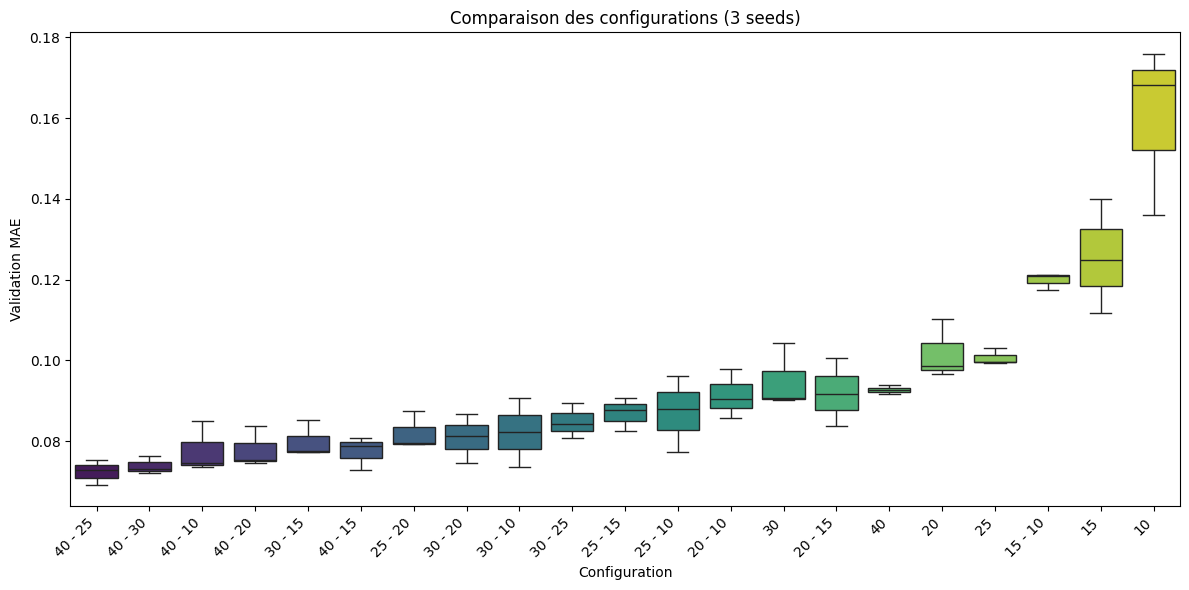

In [36]:
import seaborn as sns

df_runs = results.copy()
df_runs["config"] = df_runs["layers"].apply(lambda x: " - ".join(map(str, x)))

# Ordre par médiane croissante
order = df_runs.groupby("config")["val_mae_best"].median().sort_values().index

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_runs, x="config", y="val_mae_best", order=order, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Configuration")
plt.ylabel("Validation MAE")
plt.title("Comparaison des configurations (3 seeds)")
plt.tight_layout()
plt.show()

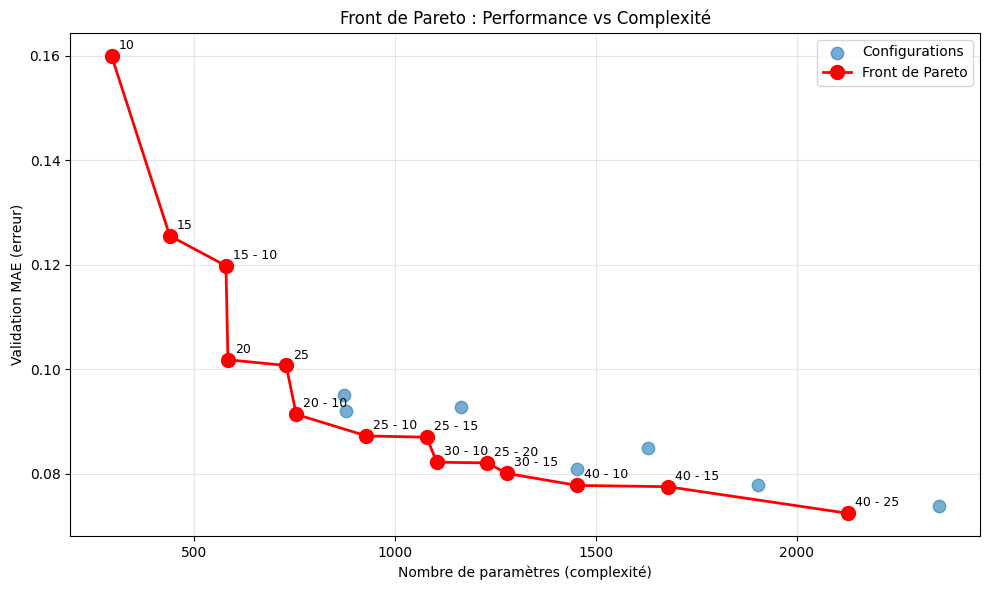

Configurations sur le front de Pareto :
 config  params  val_mae
     10     294 0.160007
     15     439 0.125539
15 - 10     579 0.119789
     20     584 0.101803
     25     729 0.100713
20 - 10     754 0.091357
25 - 10     929 0.087226
25 - 15    1079 0.086975
30 - 10    1104 0.082197
25 - 20    1229 0.082058
30 - 15    1279 0.080044
40 - 10    1454 0.077747
40 - 15    1679 0.077509
40 - 25    2129 0.072406


In [38]:
# Front de Pareto : val_mae vs nb de paramètres
import matplotlib.pyplot as plt
import numpy as np

# Données agrégées par config
df_pareto = (
    results
    .groupby("layers", as_index=False)
    .agg(val_mae=("val_mae_best", "mean"), params=("params", "first"))
)
df_pareto["config"] = df_pareto["layers"].apply(lambda x: " - ".join(map(str, x)))

# Identification du front de Pareto (minimiser les deux)
def pareto_front(df, x_col, y_col):
    sorted_df = df.sort_values(x_col).reset_index(drop=True)
    pareto_idx = []
    y_min = np.inf
    for i, row in sorted_df.iterrows():
        if row[y_col] < y_min:
            pareto_idx.append(i)
            y_min = row[y_col]
    return sorted_df.iloc[pareto_idx]

pareto = pareto_front(df_pareto, "params", "val_mae")

# Tracé
plt.figure(figsize=(10, 6))
plt.scatter(df_pareto["params"], df_pareto["val_mae"], s=80, alpha=0.6, label="Configurations")
plt.plot(pareto["params"], pareto["val_mae"], "r-o", lw=2, markersize=10, label="Front de Pareto")

# Annotations des points Pareto
for _, row in pareto.iterrows():
    plt.annotate(row["config"], (row["params"], row["val_mae"]), 
                 textcoords="offset points", xytext=(5, 5), fontsize=9)

plt.xlabel("Nombre de paramètres (complexité)")
plt.ylabel("Validation MAE (erreur)")
plt.title("Front de Pareto : Performance vs Complexité")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Affichage des configs sur le front
print("Configurations sur le front de Pareto :")
print(pareto[["config", "params", "val_mae"]].to_string(index=False))

Entraînement config : 40 → 10

▶ Seed 0
  val_mae_best = 0.07360 | test_mae = 0.07087 | epochs = 200

▶ Seed 1
  val_mae_best = 0.08507 | test_mae = 0.08169 | epochs = 200

▶ Seed 2
  val_mae_best = 0.07458 | test_mae = 0.07347 | epochs = 200

Résumé des 3 seeds :
 seed  val_mae  test_mae
    0 0.073597  0.070866
    2 0.074577  0.073474
    1 0.085066  0.081688

Moyenne : val_mae = 0.07775 | test_mae = 0.07534
Std     : val_mae = 0.00636 | test_mae = 0.00565

✓ Meilleur modèle : seed 0


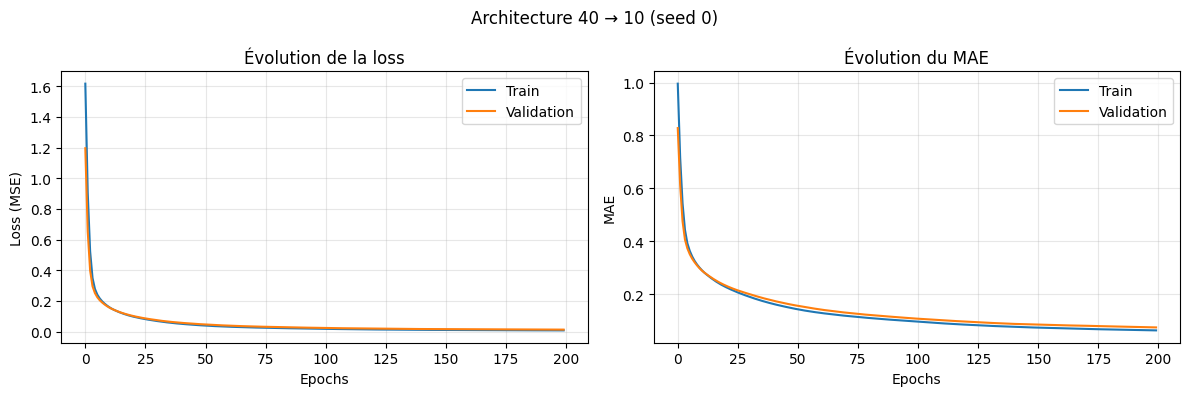

In [41]:
# Entraînement de l'architecture 40-10 sur 3 seeds
best_layers = [40, 10]
SEEDS = [0, 1, 2]

print("="*60)
print(f"Entraînement config : {' → '.join(map(str, best_layers))}")
print("="*60)

histories = {}
es = keras.callbacks.EarlyStopping(monitor="val_mae", patience=20, restore_best_weights=True)

for seed in SEEDS:
    print(f"\n▶ Seed {seed}")
    tf.keras.utils.set_random_seed(seed)
    
    model = build_model(best_layers)
    hist = model.fit(
        X_train_s, y_train,
        validation_data=(X_val_s, y_val),
        epochs=200,
        batch_size=128,
        callbacks=[es],
        verbose=0
    )
    
    test_loss, test_mae = model.evaluate(X_test_s, y_test, verbose=0)
    val_mae_best = min(hist.history["val_mae"])
    
    histories[seed] = {"model": model, "history": hist, "test_mae": test_mae, "val_mae": val_mae_best}
    print(f"  val_mae_best = {val_mae_best:.5f} | test_mae = {test_mae:.5f} | epochs = {len(hist.history['loss'])}")

# Résumé
print("\n" + "="*60)
print("Résumé des 3 seeds :")
eval_df = pd.DataFrame([
    {"seed": s, "val_mae": h["val_mae"], "test_mae": h["test_mae"]} 
    for s, h in histories.items()
]).sort_values("val_mae")
print(eval_df.to_string(index=False))
print(f"\nMoyenne : val_mae = {eval_df['val_mae'].mean():.5f} | test_mae = {eval_df['test_mae'].mean():.5f}")
print(f"Std     : val_mae = {eval_df['val_mae'].std():.5f} | test_mae = {eval_df['test_mae'].std():.5f}")

# Meilleur modèle (seed avec val_mae min)
best_seed = int(eval_df.iloc[0]["seed"])
model_A = histories[best_seed]["model"]
history = histories[best_seed]["history"]
print(f"\n✓ Meilleur modèle : seed {best_seed}")

# Courbes d'apprentissage du meilleur
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history["loss"], label="Train")
axes[0].plot(history.history["val_loss"], label="Validation")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss (MSE)")
axes[0].set_title("Évolution de la loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history["mae"], label="Train")
axes[1].plot(history.history["val_mae"], label="Validation")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("MAE")
axes[1].set_title("Évolution du MAE")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle(f"Architecture 40 → 10 (seed {best_seed})", fontsize=12)
plt.tight_layout()
plt.show()

R² par sortie :
  Avant: 0.9641
  Arrière: 0.9132
  Droit: 0.9446
  Gauche: 0.9953
R² moyen : 0.9543


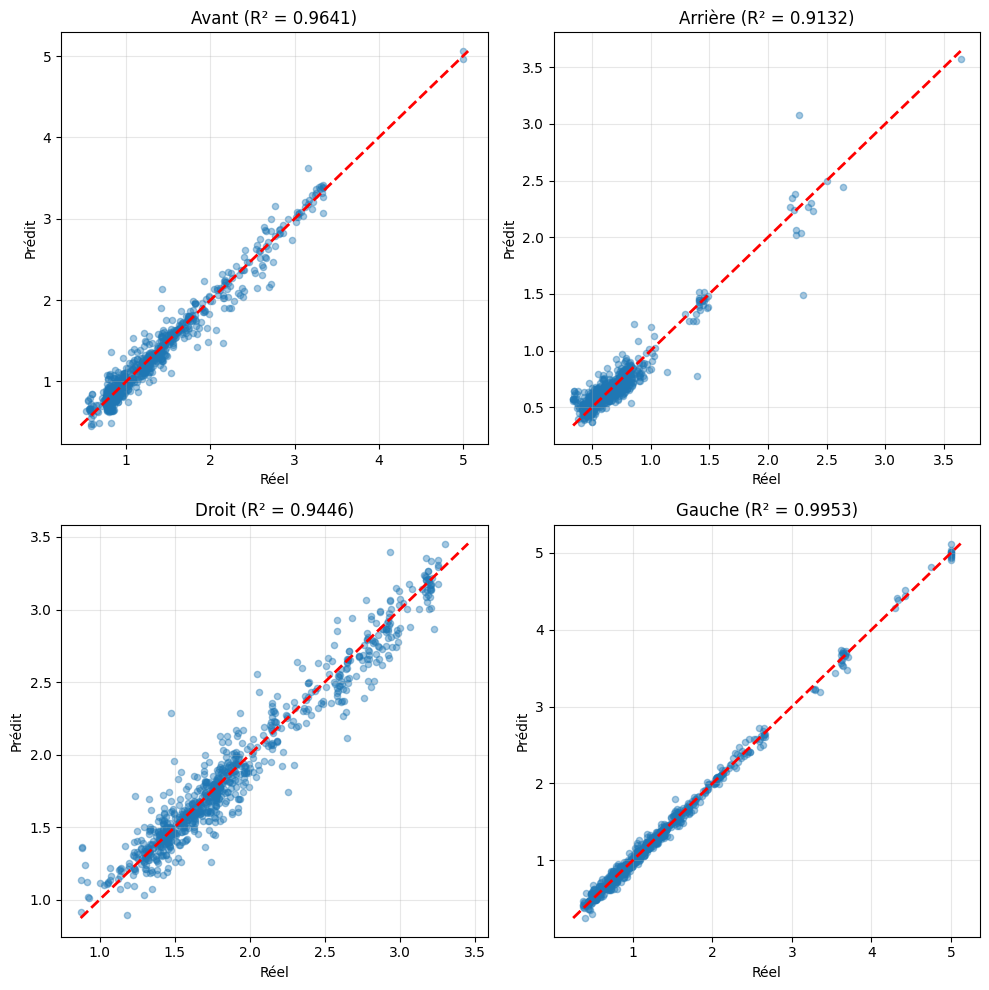

In [42]:
# R² et scatter plots
y_pred = model_A.predict(X_test_s, verbose=0)
output_names = ["Avant", "Arrière", "Droit", "Gauche"]

r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(4)]

print("R² par sortie :")
for name, r2 in zip(output_names, r2_scores):
    print(f"  {name}: {r2:.4f}")
print(f"R² moyen : {np.mean(r2_scores):.4f}")

# Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, (ax, name, r2) in enumerate(zip(axes.flat, output_names, r2_scores)):
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.4, s=20)
    lims = [min(y_test[:, i].min(), y_pred[:, i].min()),
            max(y_test[:, i].max(), y_pred[:, i].max())]
    ax.plot(lims, lims, 'r--', lw=2)
    ax.set_xlabel("Réel")
    ax.set_ylabel("Prédit")
    ax.set_title(f"{name} (R² = {r2:.4f})")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
# Sauvegarde : meilleur seed + modèle + scaler
import joblib

# Meilleure seed = min(val_mae_best)
best_seed = int(eval_df.iloc[0]["seed"])
best_model = histories[best_seed]["model"]

# Sauvegarde du modèle
MODEL_PATH = "/kaggle/working/model_A_40_10.keras"
best_model.save(MODEL_PATH)

# Sauvegarde du scalerX
SCALER_PATH = "/kaggle/working/scalerX_A.pkl"
joblib.dump(scalerX, SCALER_PATH)

Sauvegarde effectuée :
  ✓ Modèle : /kaggle/working/model_A_40_10.keras
  ✓ Scaler : /kaggle/working/scalerX_A.pkl
  ✓ Seed   : 0
  ✓ Config : 40 → 10
  ✓ Val MAE  : 0.07360
  ✓ Test MAE : 0.07087


In [47]:
# === Chargement des modèles et préprocesseurs ===
import joblib
import numpy as np
import pandas as pd
from tensorflow import keras

MODEL_A_PATH = "/kaggle/input/modela/tensorflow2/default/1/model_A_40_10.keras"
MODEL_B_PATH = "/kaggle/input/classification-commandes/keras/default/1/best_model_classification.keras"
SCALER_A_PATH = "/kaggle/input/modela/tensorflow2/default/1/scalerX_A.pkl"
ENCODER_B_PATH = "/kaggle/input/encoder/other/default/1/label_encoder_command.pkl"

# Chargement
model_A = keras.models.load_model(MODEL_A_PATH)
model_B = keras.models.load_model(MODEL_B_PATH)
scaler_A = joblib.load(SCALER_A_PATH)
encoder_B = joblib.load(ENCODER_B_PATH)

print("✓ Modèle B chargé")
print("✓ Encodeur chargé")
print(f"Classes : {encoder_B.categories_[0]}")

✓ Modèle B chargé
✓ Encodeur chargé
Classes : ['Move-Forward' 'Sharp-Right-Turn' 'Slight-Left-Turn' 'Slight-Right-Turn']


In [49]:
# === Récupérer les vraies commandes (dernière colonne de df24) ===
commands_all = df24.iloc[:, -1].values
y_test_commands = commands_all[idx_test]

print(f"Test set : {len(y_test_commands)} échantillons")
print(f"Exemple : {y_test_commands[:5]}")

Test set : 819 échantillons
Exemple : ['Slight-Right-Turn' 'Slight-Right-Turn' 'Move-Forward' 'Move-Forward'
 'Slight-Right-Turn']


SYSTÈME COMPLET : 24 capteurs → Réseau A → Réseau B → Commande

Accuracy : 0.8400 (84.00%)

                   precision    recall  f1-score   support

     Move-Forward       0.77      0.91      0.83       328
 Sharp-Right-Turn       0.93      0.89      0.91       333
 Slight-Left-Turn       0.85      0.81      0.83        48
Slight-Right-Turn       0.83      0.49      0.62       110

         accuracy                           0.84       819
        macro avg       0.84      0.78      0.80       819
     weighted avg       0.85      0.84      0.83       819



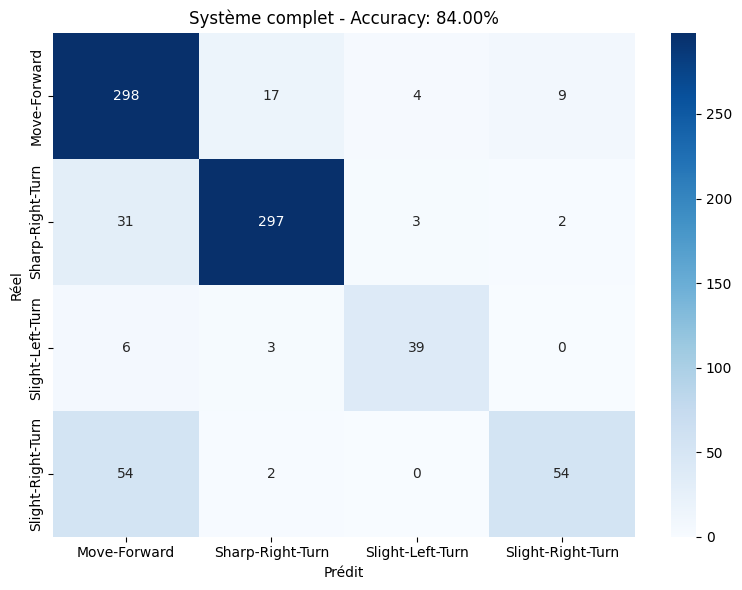

In [50]:
# === Pipeline système complet ===
# Étape 1 : X_test_s (24 capteurs normalisés) - déjà fait
# Étape 2 : Réseau A (24 → 4)
X_test_4 = model_A.predict(X_test_s, verbose=0)

# Étape 3 : Réseau B (4 → commande)
y_proba = model_B.predict(X_test_4, verbose=0)
y_pred_idx = np.argmax(y_proba, axis=1)
y_pred_commands = encoder_B.categories_[0][y_pred_idx]

# === Évaluation ===
accuracy = accuracy_score(y_test_commands, y_pred_commands)
print("="*60)
print("SYSTÈME COMPLET : 24 capteurs → Réseau A → Réseau B → Commande")
print("="*60)
print(f"\nAccuracy : {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\n" + classification_report(y_test_commands, y_pred_commands))

# Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_commands, y_pred_commands, labels=encoder_B.categories_[0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder_B.categories_[0],
            yticklabels=encoder_B.categories_[0])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title(f"Système complet - Accuracy: {accuracy:.2%}")
plt.tight_layout()
plt.show()

In [51]:
# === Analyse des erreurs ===
errors_mask = y_test_true != y_pred_commands
n_errors = np.sum(errors_mask)
print(f"Erreurs : {n_errors}/{len(y_test_true)} ({n_errors/len(y_test_true)*100:.2f}%)")

if n_errors > 0:
    errors_df = pd.DataFrame({'Réel': y_test_true[errors_mask], 'Prédit': y_pred_commands[errors_mask]})
    print("\nTypes d'erreurs :")
    print(errors_df.groupby(['Réel', 'Prédit']).size().sort_values(ascending=False))

Erreurs : 131/819 (16.00%)

Types d'erreurs :
Réel               Prédit           
Slight-Right-Turn  Move-Forward         54
Sharp-Right-Turn   Move-Forward         31
Move-Forward       Sharp-Right-Turn     17
                   Slight-Right-Turn     9
Slight-Left-Turn   Move-Forward          6
Move-Forward       Slight-Left-Turn      4
Slight-Left-Turn   Sharp-Right-Turn      3
Sharp-Right-Turn   Slight-Left-Turn      3
                   Slight-Right-Turn     2
Slight-Right-Turn  Sharp-Right-Turn      2
dtype: int64
